# Examen 1 Aldo Cervantes

El programa consiste en realizar una predicción de la acción de control de un controlador basado en el entrenamiento de una red neuronal perceptrón multicapa de un controlador PID.

El sistema a controlar será la posición de un motor electrico de corriente directa (CD). Su función de transferencia es:
$$\frac{\theta(s)}{I(s)}=\frac{K}{s(s+a)}$$
Donde $K$ y $a$ son las constantes del motor.

Al aplicar la transformada z al sistema es posible obtener una función recursiva mediante el teorema del corrimiento:
$$ \theta(k)=K(-e^{-a}+1)I(k-1)+ (e^{-a}+1)\theta(k-1)-e^{-a}\theta(k-2)$$


Para entrenar la red, se ocuparán casos de controladores PID actuando sobre el sistema, generando una base de datos con distintos casos. El controlador PID tiene la siguiente forma.
$$I(t)=U(t)=k_pe(t)+k_i\int e(t)dt+k_d\frac{de(t)}{dt}$$
donde:
- $k_p$,$k_i$ y $k_d$ son constantes (ganancias) del sistema, los cuales afectan el comportamiento de la respuesta.

Aplicando la transformada z y aplicando teoremas de corrimento se obtiene:

- Tomando en cuenta un periodo de muestreo $T$.
- $k_{pd}=k_p$
- $k_{id}=k_iT$
- $k_{dd}=\frac{k_d}{T}$

$$U(k)=U(k-1)+(c_0e(k))+(c_1e(k-1))+(c_2e(k-2))$$

Donde:
- $c_0=k_{pd}+k_{id}+k_{dd}$
- $c_1=-k_{pd}-2k_{dd}$
- $c_2=k_{dd}$

In [153]:
import numpy as np


def motor(k,a,i_1,sal_1,sal_2):
    sal=((i_1*(-np.exp(-a)+1)*k)+((np.exp(-a)+1)*sal_1)-(sal_2*np.exp(-a)))
    #sal=((1-a)i_1)
    return sal

def controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1):
    u=u_1+(c_0*e)+(c_1*e_1)+(c_2*e_2)
    if abs(u)>12.5 and u<0: #saturación de voltaje
        u=-12.5
    elif abs(u)>12.5 and u>0:
        u=12.5
    u=u*0.0557 #conversión a tensión
    return u

perturbacion=0.3
u=0
u_1=0
e=0
e_1=0
e_2=0
sal=0
sal_1=0
sal_2=0
T=0.01
k=7.613
a=0.14
kp=4
ki=5
kd=0.1
kpd=kp
kid=ki*T
kdd=kd/T
c_0=kpd+kid+kdd
c_1=-kpd-2*kdd
c_2=kdd
#a=np.exp(-50/7)*T

Teniendo como salida final (salida compensada):
$$\theta_{final}(k)= \theta(U(k)) $$

$$U(k)=U(in(k))$$

$$e(k)=sp-\theta_{final}(k)$$

La principal idea es minimizar el error a 0 y por lo tanto se acercará al valor deseado.

In [154]:
sp=0.65 #Valor deseado en radianes

La red neuronal tendrá de entrada:
$$\begin{bmatrix}
     e(0)&
     e(-1)&
     e(-2)&
     in(0) &
     in(-1)&
     out(-1)&
     out(-2) \\
     e(1)&
     e(0)&
     e(-1)&
     in(1) &
     in(0)&
     out(0)&
     out(-1) \\
     \vdots &
     \vdots &
     \vdots &
     \vdots &
     \vdots &
     \vdots &
     \vdots \\
     e(k)&
     e(k-1)&
     e(k-2)&
     in(k) &
     in(k-1)&
     out(k-1)&
     out(k-2)
\end{bmatrix}$$

Teniendo de única salida:

$$\begin{bmatrix} 
    out(0)\\
    out(1)\\  
    \vdots \\
    out(k)
\end{bmatrix}$$

In [155]:
t=[]
aa=-sp
b=sp
e=sp-sal
#x=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
#x=np.array([[e,u,sal]])
x=np.array([[e,e_1,e_2]])
y=np.array([[sal]])
bandera=0
sp2=np.array([sp])
import time 
import random
for tiempo in range(6000):
    t1=time.time()
    #sp=np.sin(tiempo*1.5*T)
    e=sp-sal
    u=controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1)

    sal=motor(k,a,u_1,sal_1,sal_2)
    
    #print([e,u,sal])
    #x=np.vstack((x,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    #x=np.vstack((x,np.array([[e,u,sal]])))
    x=np.vstack((x,np.array([[e,e_1,e_2]])))
    y=np.vstack((y,np.array([[sal]])))
    sp2=np.vstack((sp2,np.array([sp])))
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
    t.append(tiempo*T)
    if abs(e)<=0.0017:
        bandera+=1
        r=random.uniform(aa,b)
        sp=r
    t2=time.time()
    """
   # if t2-t1<=0.0009:
    #    T=0.001
    #else:
    #    T=t2-t1
    kpd=kp  #Recalcular ganancias por diferencias de tiempo discreto
    kid=ki*T
    kdd=kd/T
    c_0=kpd+kid+kdd
    c_1=-kpd-2*kdd
    c_2=kdd
    """
    

In [156]:
x.shape

(6001, 3)

In [157]:
y.shape

(6001, 1)

# Patrón de entrenamiento

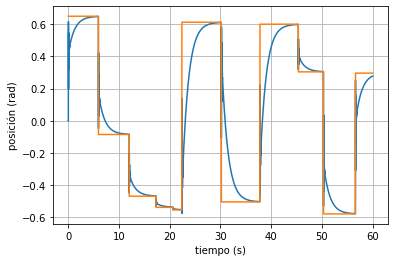

In [158]:
import matplotlib.pyplot as plt
t=np.arange(0,6001,1)
plt.plot(t*T,y)
plt.plot(t*T,sp2)
plt.xlabel('tiempo (s)')
plt.ylabel('posición (rad)')
plt.grid()

In [159]:
print('salida máxima:',y.max(),'rad')
print('error máximo:',x[:,0].max(),'rad')

salida máxima: 0.6483306814738711 rad
error máximo: 1.1876919588681767 rad


# Red Perceptrón multicapa

In [160]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model,Sequential

#normalización del valor
#n_min=0
#n_max=1
#x[:,1]=(x[:,1]-x[:,1].min())/(x[:,1].max()-x[:,1].min())
#x[:,0]=(x[:,0]-x[:,0].min())/(x[:,0].max()-x[:,0].min())

model=Sequential()
model.add(Dense(8,input_shape=(3,),activation='linear')) ## era 7
model.add(Dense(14,activation='linear'))
model.add(Dense(28,activation='linear'))
model.add(Dense(14, activation='linear'))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_16 (Dense)             (None, 14)                126       
_________________________________________________________________
dense_17 (Dense)             (None, 28)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 14)                406       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 15        
Total params: 999
Trainable params: 999
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
t1=time.time()
model.fit(x,y,epochs=10,batch_size=1,verbose=1)
t2=time.time()
print('tiempo de ejecución',t2-t1)

Epoch 1/10
6001/6001 [==============================] - 5s 797us/step - loss: 0.2050
Epoch 2/10
6001/6001 [==============================] - 4s 722us/step - loss: 0.2032
Epoch 3/10
6001/6001 [==============================] - 4s 590us/step - loss: 0.2027
Epoch 4/10
6001/6001 [==============================] - 4s 588us/step - loss: 0.2024
Epoch 5/10
6001/6001 [==============================] - 4s 589us/step - loss: 0.2021
Epoch 6/10
6001/6001 [==============================] - 4s 594us/step - loss: 0.2025
Epoch 7/10
6001/6001 [==============================] - 4s 590us/step - loss: 0.2021
Epoch 8/10
6001/6001 [==============================] - 4s 588us/step - loss: 0.2021
Epoch 9/10
6001/6001 [==============================] - 4s 591us/step - loss: 0.2019
Epoch 10/10
6001/6001 [==============================] - 4s 589us/step - loss: 0.2017
tiempo de ejecución 37.89456748962402


# Prueba de desempeño

Error cuadrático medio

$$RMSE=\sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y})^2}{n}}$$

Sobrepaso

$$m_p[\%]=(1-\frac{|y_{max}|}{s_p})*100\%$$

Tiempo de asentamiento
$$t_s=t(e_{min})$$

# Prueba de control

Las pruebas consistirán en 3 diferentes funciones de $setpoint$ para poder observar el desempeño del sistema.

## 1 Prueba de escalón

Consiste en una función:
$$s_p(\theta)=\left\{\begin{matrix}
 0 & t < 0 \\ 
 a & t\geq 0
\end{matrix}\right. $$

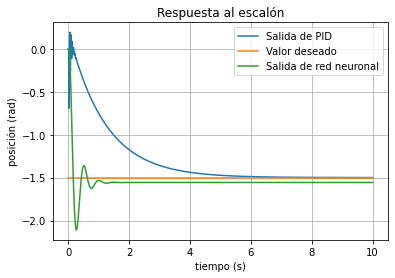

In [170]:
sp=-1.5
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=0 #Posición inicial
sal_1=0
sal_2=0
T=0.01
t=[]
aa=-sp
b=sp
e=sp-sal
x=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
y=np.array([[sal]])

sp2=np.array([sp])
for tt in range(1000):
    e=sp-sal
    #e_n=sp-sal_n
    u=controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1)

    sal=motor(k,a,u_1,sal_1,sal_2)
    
    #print([e,u,sal])
    x=np.vstack((x,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    y=np.vstack((y,np.array([[sal]])))
    sp2=np.vstack((sp2,np.array([sp])))
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e

u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=0 #Posición inicial
sal_1=0
sal_2=0
#x2=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
#x2=np.array([[e,u,sal]])
x2=np.array([[e,e_1,e_2]])
y2=np.array([[sal]])
#"""
for tt in range(1000):
    e=sp-sal

    #u=model.predict(x2) #No deja hacer una predicción por renglón
    #u=model.predict([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
    #u=model.predict([[e,u,sal]])
    u=model.predict([[e,e_1,e_2]])
    u=float(u)
    if abs(u)>12.5 and u<0: #saturación de voltaje
        u=-12.5
    elif abs(u)>12.5 and u>0:
        u=12.5
    u=u*0.0557 #conversión a tensión

    
    #u=u*0.0557 #conversión a tensión
    sal=motor(k,a,u_1,sal_1,sal_2)
    #print([e,u,sal])
    #x2=np.vstack((x2,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    #x2=np.vstack((x2,np.array([[e,u,sal]])))
    x2=np.vstack((x2,np.array([[e,e_1,e_2]])))
    y2=np.vstack((y2,np.array([[sal]])))
    
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
#"""

t=np.arange(0,1001,1)
plt.plot(t*0.01,y)
plt.plot(t*0.01,sp2)
t2=np.arange(0,1001,1)
plt.plot(0.01*t,y2)
plt.xlabel('tiempo (s)')
plt.ylabel('posición (rad)')
plt.title('Respuesta al escalón')
plt.legend(['Salida de PID','Valor deseado','Salida de red neuronal'],loc='upper right')
plt.grid()

### Prueba de desempeño


In [171]:
## Red neuronal
rmse1=float(np.sqrt((sum(y2-y2.mean())**2)/len(y2)))
print('Error medio cuadratico:',rmse1)
m_p1=float((1-(abs(x2[:,0].max())/sp2[np.where(abs(x2[:,0])==abs(x2[:,0].max()))]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x2[:,0]==x2[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')
## PID
rmse1pid=float(np.sqrt((sum(y-y.mean())**2)/len(y)))
print('Error medio cuadratico:',rmse1pid)
x_aux1=np.where(abs(x[:,0])==abs(x[:,0].max()))
m_p1=float((1-(abs(x[:,0].max())/sp2[x_aux1[0]]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x[:,0]==x[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')

Error medio cuadratico: 2.273883430016094e-15
Sobrepaso: 140.60444707877025 %
Tiempo de asentamiento: 0.03 s
Error medio cuadratico: 2.3861739697699754e-16
Sobrepaso: 100.02805241907157 %
Tiempo de asentamiento: 0.06 s


## 2 Prueba sinusoidal

Consiste en la función:
$$s_p(\theta)=a\sin(\omega t + \alpha) $$

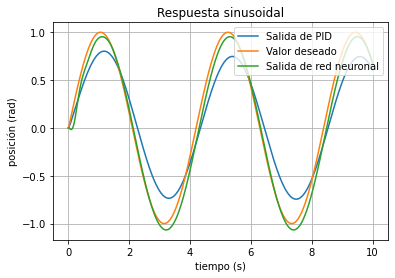

In [172]:
sp=0
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=0 #Posición inicial
sal_1=0
sal_2=0
T=0.01
t=[]
aa=-sp
b=sp
e=sp-sal
x=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
y=np.array([[sal]])

sp2=np.array([sp])
for tt in range(1000):
    sp=np.sin(tt*1.5*T)
    e=sp-sal
    #e_n=sp-sal_n
    u=controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1)

    sal=motor(k,a,u_1,sal_1,sal_2)
    
    #print([e,u,sal])
    x=np.vstack((x,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    y=np.vstack((y,np.array([[sal]])))
    sp2=np.vstack((sp2,np.array([sp])))
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e

u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=0 #Posición inicial
sal_1=0
sal_2=0
#x2=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
#x2=np.array([[e,u,sal]])
x2=np.array([[e,e_1,e_2]])
y2=np.array([[sal]])
#"""
for tt in range(1000):
    sp=np.sin(tt*T*1.5)
    e=sp-sal
    #u=model.predict(x2) #No deja hacer una predicción por renglón
    #u=model.predict([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
    #u=model.predict([[e,u,sal]])
    u=model.predict([[e,e_1,e_2]])
    u=float(u)
    if abs(u)>12.5 and u<0: #saturación de voltaje
        u=-12.5
    elif abs(u)>12.5 and u>0:
        u=12.5
    u=u*0.0557 #conversión a tensión

    
    #u=u*0.0557 #conversión a tensión
    sal=motor(k,a,u_1,sal_1,sal_2)
    #print([e,u,sal])
    #x2=np.vstack((x2,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    #x2=np.vstack((x2,np.array([[e,u,sal]])))
    x2=np.vstack((x2,np.array([[e,e_1,e_2]])))
    y2=np.vstack((y2,np.array([[sal]])))
    
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
    
    
t=np.arange(0,1001,1)
plt.plot(t*T,y)
plt.plot(t*T,sp2)
t2=np.arange(0,1001,1)
plt.plot(T*t2,y2)
plt.xlabel('tiempo (s)')
plt.ylabel('posición (rad)')
plt.title('Respuesta sinusoidal')
plt.legend(['Salida de PID','Valor deseado','Salida de red neuronal'],loc='upper right')
plt.grid()

## Prueba de desempeño

In [173]:
rmse1=float(np.sqrt((sum(y2-y2.mean())**2)/len(y2)))
print('Error medio cuadratico:',rmse1)
m_p1=float((1-(abs(x2[:,0].max())/sp2[np.where(abs(x2[:,0])==abs(x2[:,0].max()))]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x2[:,0]==x2[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')
## PID
rmse1pid=float(np.sqrt((sum(y-y.mean())**2)/len(y)))
print('Error medio cuadratico:',rmse1)
x_aux1=np.where(abs(x[:,0])==abs(x[:,0].max()))
m_p1=float((1-(abs(x[:,0].max())/sp2[x_aux1[0]]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x[:,0]==x[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')

Error medio cuadratico: 1.7861213979601726e-15
Sobrepaso: 17.256893218377613 %
Tiempo de asentamiento: 6.2700000000000005 s
Error medio cuadratico: 1.7861213979601726e-15
Sobrepaso: 61.55743569588235 %
Tiempo de asentamiento: 2.7600000000000002 s


## Prueba de pata robótica

La pata robótica tiene 2 diferentes $setpoints$, para cada grado de libertad $\theta_n$:
$$\theta_1=d\phi-A\phi(cos(\xi)-1) $$

$$\theta_2=d\beta-A\beta(cos(\xi)-1)e^{k1\xi}$$

$$\theta_3=d\chi-A\chi(cos(\xi)-1)e^{k1\xi}$$

con $k_1$:
$$k_1=\frac{1}{c^2\sqrt{2\pi}}e^{-\frac{(\xi-b)^2}{2c^2}} $$

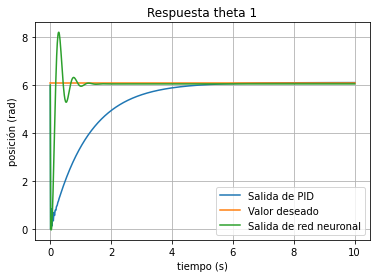

In [174]:
########################## theta 1 #########################################
sp=(350-(350*(np.cos(0*(np.pi/180))-1)))*(np.pi/180)
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=6 #Posición inicial
sal_1=0
sal_2=0
T=0.01
t=[]
aa=-sp
b=sp
e=sp-sal
x=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
y=np.array([[sal]])

sp2=np.array([sp])
for tt in range(1000):
    
    sp=(350-(350*(np.cos(tt*0.001*(np.pi/180))-1)))*(np.pi/180)
    e=sp-sal
    #e_n=sp-sal_n
    u=controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1)

    sal=motor(k,a,u_1,sal_1,sal_2)
    
    #print([e,u,sal])
    x=np.vstack((x,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    y=np.vstack((y,np.array([[sal]])))
    sp2=np.vstack((sp2,np.array([sp])))
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
#"""
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=6 #Posición inicial
sal_1=0
sal_2=0
#x2=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
#x2=np.array([[e,u,sal]])
x2=np.array([[e,e_1,e_2]])
y2=np.array([[sal]])

for tt in range(1000):
    
    sp=(350-(350*(np.cos(tt*0.001*(np.pi/180))-1)))*(np.pi/180)
    e=sp-sal
    #u=model.predict(x2) #No deja hacer una predicción por renglón
    #u=model.predict([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
    #u=model.predict([[e,u,sal]])
    u=model.predict([[e,e_1,e_2]])
    u=float(u)
    if abs(u)>12.5 and u<0: #saturación de voltaje
        u=-12.5
    elif abs(u)>12.5 and u>0:
        u=12.5
    u=u*0.0557 #conversión a tensión

    
    #u=u*0.0557 #conversión a tensión
    sal=motor(k,a,u_1,sal_1,sal_2)
    #print([e,u,sal])
    #x2=np.vstack((x2,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    #x2=np.vstack((x2,np.array([[e,u,sal]])))
    x2=np.vstack((x2,np.array([[e,e_1,e_2]])))
    y2=np.vstack((y2,np.array([[sal]])))
    
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
    
#"""    
t=np.arange(0,1001,1)
plt.plot(0.01*t,y)
plt.plot(0.01*t,sp2)
t2=np.arange(0,1001,1)
plt.plot(0.01*t2,y2)
plt.xlabel('tiempo (s)')
plt.ylabel('posición (rad)')
plt.title('Respuesta theta 1')
plt.legend(['Salida de PID','Valor deseado','Salida de red neuronal'],loc='lower right')
plt.grid()

## Prueba de desempeño

In [175]:
rmse1=float(np.sqrt((sum(y2-y2.mean())**2)/len(y2)))
print('Error medio cuadratico:',rmse1)
m_p1=float((1-(abs(x2[:,0].max())/sp2[np.where(abs(x2[:,0])==abs(x2[:,0].max()))]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x2[:,0]==x2[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')
## PID
rmse1pid=float(np.sqrt((sum(y-y.mean())**2)/len(y)))
print('Error medio cuadratico:',rmse1pid)
x_aux1=np.where(abs(x[:,0])==abs(x[:,0].max()))
m_p1=float((1-(abs(x[:,0].max())/sp2[x_aux1[0]]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x[:,0]==x[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')

Error medio cuadratico: 6.9620134647406334e-15
Sobrepaso: -0.4600870549841707 %
Tiempo de asentamiento: 0.29 s
Error medio cuadratico: 3.9470124723489237e-14
Sobrepaso: 0.0 %
Tiempo de asentamiento: 10.0 s


## Prueba de pata robótica segunda parte


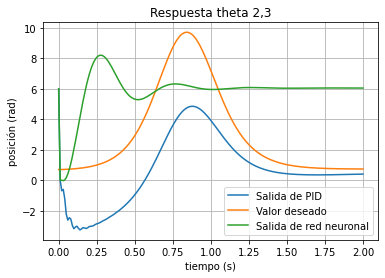

In [176]:
########################## theta 2,3 #########################################
sigma=0.6
mu=1.2
k_1=(1/(np.sqrt(2)*sigma**2))*np.exp(-((0-mu)**2/(2*sigma**2)))
sp=(40-(1*(np.cos(0)-1)))*np.exp(k_1*0)*(np.pi/180)
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=6 #Posición inicial
sal_1=0
sal_2=0
T=0.01
t=[]
aa=-sp
b=sp
e=sp-sal
x=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
y=np.array([[sal]])

sp2=np.array([sp])
for tt in range(200):
    
    k_1=(1/(np.sqrt(2)*sigma**2))*np.exp(-(((tt*np.pi/180)-mu)**2/(2*sigma**2)))
    sp=(40-(1*(np.cos(tt*np.pi/180)-1)))*np.exp(k_1*(tt*np.pi/180))*(np.pi/180)
    e=sp-sal
    #e_n=sp-sal_n
    u=controlador_pid(c_0,c_1,c_2,e,e_1,e_2,u_1)

    sal=motor(k,a,u_1,sal_1,sal_2)
    
    #print([e,u,sal])
    x=np.vstack((x,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    y=np.vstack((y,np.array([[sal]])))
    sp2=np.vstack((sp2,np.array([sp])))
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
#"""
sigma=0.6
mu=1.2
k_1=(1/(np.sqrt(2)*sigma**2))*np.exp(-((0-mu)**2/(2*sigma**2)))
sp=(40-(1*(np.cos(0)-1)))*np.exp(k_1*0)*(np.pi/180)
u=0
u_1=0
e=sp-sal
e_1=0
e_2=0
sal=6 #Posición inicial
sal_1=0
sal_2=0
#x2=np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
#x2=np.array([[e,u,sal]])
x2=np.array([[e,e_1,e_2]])
y2=np.array([[sal]])

for tt in range(200):
    
    k_1=(1/(np.sqrt(2)*sigma**2))*np.exp(-(((tt*np.pi/180)-mu)**2/(2*sigma**2)))
    sp=(40-(1*(np.cos(tt*np.pi/180)-1)))*np.exp(k_1*(tt*np.pi/180))*(np.pi/180)
    sp=(350-(350*(np.cos(tt*0.001*(np.pi/180))-1)))*(np.pi/180)
    e=sp-sal
    #u=model.predict(x2) #No deja hacer una predicción por renglón
    #u=model.predict([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]) #
    #u=model.predict([[e,u,sal]])
    u=model.predict([[e,e_1,e_2]])
    u=float(u)
    if abs(u)>12.5 and u<0: #saturación de voltaje
        u=-12.5
    elif abs(u)>12.5 and u>0:
        u=12.5
    u=u*0.0557 #conversión a tensión

    
    #u=u*0.0557 #conversión a tensión
    sal=motor(k,a,u_1,sal_1,sal_2)
    #print([e,u,sal])
    #x2=np.vstack((x2,np.array([[e,e_1,e_2,u,u_1,sal_1,sal_2,sal]]))) #
    #x2=np.vstack((x2,np.array([[e,u,sal]])))
    x2=np.vstack((x2,np.array([[e,e_1,e_2]])))
    y2=np.vstack((y2,np.array([[sal]])))
    
    u_1=u
    sal_2=sal_1
    sal_1=sal
    e_2=e_1
    e_1=e
    
#"""    
t=np.arange(0,201,1)
plt.plot(t*0.01,y)
plt.plot(t*0.01,sp2)
t2=np.arange(0,201,1)
plt.plot(t*0.01,y2)
plt.xlabel('tiempo (s)')
plt.ylabel('posición (rad)')
plt.title('Respuesta theta 2,3')
plt.legend(['Salida de PID','Valor deseado','Salida de red neuronal'],loc='lower right')
plt.grid()

## Prueba de desempeño

In [177]:
rmse1=float(np.sqrt((sum(y2-y2.mean())**2)/len(y2)))
print('Error medio cuadratico:',rmse1)
m_p1=float((1-(abs(x2[:,0].max())/sp2[np.where(abs(x2[:,0])==abs(x2[:,0].max()))]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x2[:,0]==x2[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')
## PID
rmse1pid=float(np.sqrt((sum(y-y.mean())**2)/len(y)))
print('Error medio cuadratico:',rmse1pid)
x_aux1=np.where(abs(x[:,0])==abs(x[:,0].max()))
m_p1=float((1-(abs(x[:,0].max())/sp2[x_aux1[0]]))*100)
print('Sobrepaso:',m_p1,'%')
t_aux1=t[np.where(x[:,0]==x[:,0].min())]
t_s1=float(t[t_aux1[0]]*0.01)
print('Tiempo de asentamiento:',t_s1,'s')

Error medio cuadratico: 3.7588365266142085e-16
Sobrepaso: -764.6028960833164 %
Tiempo de asentamiento: 0.29 s
Error medio cuadratico: 2.5332992007493675e-15
Sobrepaso: 41.50158480470112 %
Tiempo de asentamiento: 0.0 s
